<a href="https://colab.research.google.com/github/silver68211/My-deep-learning-project/blob/master/Text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part2: Text generation

In order to answer this part of the assignment, we will use **Word Level Text Generation**. In this case, each of the input and output tokens is a word. Moreover, Language Model outputs a probability distribution over vocabulary.


<img src="https://s18.picofile.com/file/8432180226/download.png" alt="Word Level Text Generation" style="width:100px;height:100px;">



*   In training, we supply a sequence of words as input ($X$) and a target word (next word to complete the input) as output ($Y$).
*   After training, the Language Model learns to generate **a conditional probability distribution** over the **vocabulary** of words according to the **given  input sequence**.

To generate text, we can iterate over the below steps:

<ul>
    <li><b>Step 1:</b>we provide a sequence of words to the Language Model as input.
    </li>
    <li><b>Step 2:</b>
        the Language Model outputs a conditional probability distribution over the vocabulary.
        </li>
         <li><b>Step 3:</b>
        we sample a word from the distribution.
        </li>
        <li><b>Step 4:</b>
         we concatenate the newly sampled word to the generated text
        </li>
        <li><b>Step 5:</b>
         a new input sequence is genareted by appending the newly sampled word
        </li>
</ul>


<img src="https://s18.picofile.com/file/8432182150/download.gif" alt="Word Level Text Generation" style="width:100px;height:100px;">






In [ ]:
try:
    #print tensorflew version only exists in colab
    %tensorflow_version 2.x

except Exception:
    print('Does not exist tensorflow version 2 or exists an older version')


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
SavDir = '/content/drive/MyDrive/HW2/'
%cd /content/drive/MyDrive/'HW2'/
%ls

/content/drive/MyDrive/HW2
poetry.txt  Stopwords.txt  TG_LSTM.png


In [ ]:
# Import Libraries

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, Flatten, LSTM
from tensorflow.keras.layers import BatchNormalization,Activation, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, CallbackList
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras import backend as k
from tensorflow import  keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import KFold


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import string
import re
import os

## Text preprocessing

Here, We are going to use the TensorFlow data pipeline in order to process the raw data. for more information about The TensorFlow data pipeline, you can check
[the Tensorflow website](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).
Indeed, firstly, We will create a data pipeline to prepare training data for word-level text generator. Then, we will use prepared data to train a text generation language model using **LSTM**.

Thus, in the pipeline, we will
* **open** & **load** corpus (text file).
* **convert** the text into sequence of words.
* **generate** input ($X$) and output ($Y$) tuples as word sequences.
* **remove** unwanted tokens such as punctuations, *HTML* tags, white spaces, etc.
* **vectorize** the input ($X$) and output ($Y$) tuples.
* **concatenate** input ($X$) and output ($Y$) into train data.
* **cache, prefetch, and batch** the data pipeline for performance.

### Open and load text file

Here, to load the poetry data set line by line,we are going to use
[*tf.data.TextLineDataset*](https://www.tensorflow.org/api_docs/python/tf/data/TextLineDataset) method.

In [ ]:
def LoadDataSet():

    try:
        with open(SavDir+FileName) as file:
            file.read()


    except FileNotFoundError:

        msg = 'The {} does not exist'.format(FileName)
        print(msg)

    else:

        return tf.data.TextLineDataset([SavDir+FileName])

In [ ]:
#@title Load StopWords
def LoadStopWords():

    try:
        with open(SavDir+StopFile) as file:
            StopWords = file.read().replace('\n', ' ')


    except FileNotFoundError:

        msg = 'The {} does not exist'.format(StopFile)
        print(msg)
    else:
        return StopWords

In [ ]:
FileName='poetry.txt'
StopFile='Stopwords.txt'
StopWords = LoadStopWords()
RawData=LoadDataSet()


msg='This DataSet has  {} lines.'.format(len(list(RawData.take(-1))))
print(msg)


msg='Number of Stopwords are {}.'.format(len(StopWords))
print(msg)

This DataSet has  69064 lines.
Number of Stopwords are 1698.


#### Printing some lines of uploaded data.

In [ ]:
def PrintLines(df, Num=2):

    for elm in df.take(Num):
        elm = elm.numpy()
        print(elm.decode("utf-8"))



PrintLines(RawData,10)

﻿
اول دفتر به نام ایزد دانا
صانع پروردگار حی توانا
اکبر و اعظم خدای عالم و آدم
صورت خوب آفرید و سیرت زیبا
از در بخشندگی و بنده نوازی
مرغ هوا را نصیب و ماهی دریا
قسمت خود می‌خورند منعم و درویش
روزی خود می‌برند پشه و عنقا
حاجت موری به علم غیب بداند


### Remove StopWords

Before processing the text, we are going to remove Persian stop words. therefore, we will use the following auxiliary python function.

In [ ]:
def remov_stopwords(x:tf.Tensor):
    S=''
    for Str in tf.strings.split(x).numpy():
        if (Str.decode('utf-8') not in StopWords):
            # x=tf.strings.regex_replace(x,Str.decode('utf-8'),'')
            S +=' '+Str.decode('utf-8')



    return tf.reshape(S,x.shape)

In [ ]:
CData =RawData.map(lambda x: tf.py_function(remov_stopwords,inp=[x],Tout=tf.string))
CData=CData.map(lambda x: tf.reshape(x,()))

In [ ]:
PrintLines(CData,10)

 ﻿
 دفتر ایزد دانا
 صانع پروردگار حی توانا
 اکبر اعظم خدای عالم آدم
 خوب آفرید سیرت زیبا
 بخشندگی بنده نوازی
 مرغ هوا نصیب ماهی دریا
 قسمت می‌خورند منعم درویش
 روزی می‌برند پشه عنقا
 حاجت موری علم غیب بداند


# Split test into words token


In the next step, we will first split the lines of the DataSet into a set of vectors of strings using [*Tf.strings.split*](https://www.tensorflow.org/api_docs/python/tf/strings/split) method and then for futhur procesing, we will use [*Tf.data.Dataset.from_tensor_slices(x)*](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) and [*Tf.data.Dataset.from_tensor_slices*](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#flat_map) to creat a dataset from each element of the DataSet.

In [ ]:
def DFlatten():


    df= CData.map(lambda x: tf.strings.split(x))

    ## show some sample after usinf tf.strings.split.
    OSSp = [[elm.decode('utf-8') for elm in win.numpy()] for win in df.take(5)]
    msg = 'the shape of DataSet after using tf.strings.split:\n'
    print(msg,'\n',OSSp,'\n')


    #Flatten DataSet

    df = df.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))

     ## show some sample after usinf from_tensor_slices and flat_map.
    OSSp = [elm.numpy().decode('utf-8')  for elm in df.take(10)]
    msg = 'the shape of DataSet after using from_tensor_slices and flat_map:\n'
    print(msg,'\n',OSSp,'\n')

    return df

In [ ]:
FlatData=DFlatten()

the shape of DataSet after using tf.strings.split:
 
 [['\ufeff'], ['دفتر', 'ایزد', 'دانا'], ['صانع', 'پروردگار', 'حی', 'توانا'], ['اکبر', 'اعظم', 'خدای', 'عالم', 'آدم'], ['خوب', 'آفرید', 'سیرت', 'زیبا']] 

the shape of DataSet after using from_tensor_slices and flat_map:
 
 ['\ufeff', 'دفتر', 'ایزد', 'دانا', 'صانع', 'پروردگار', 'حی', 'توانا', 'اکبر', 'اعظم'] 



In [ ]:
Num_dis_words=3837
#len(set(FlatData.as_numpy_iterator()))
#3837
#3974
# 3813

msg= 'There are {} distinct words in the {} '.format(Num_dis_words,FileName)

print(msg)

There are 3837 distinct words in the poetry.txt 


## Creat traning data and its lables

as you know, in order to train the model, we need Inputs ($X$) and their labels ($Y$). Therefore, we will split the DataSet into two DataSets as follow:

* The first dataset ($X$) is  the **input data** to the model which will hold fixed-size word sequences (*partial sentences*)
* The second dataset ($Y$) is  the **output data** which has only  one-word samples (*next word*)

To create these datasets ($X$ ***input sequence of words*** & $Y$ ***next word***), we can apply [tf.data.Dataset.window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) transformation. For employing Tf.data.Dataset.window, we first need to define the length of input sequences and then apply the window() transformation so that  each window  has ($input \,\,  sequence \,\, length +1$)  words ($|X|+|Y|$).

after window operation, since each window is a kind of dataset (**_VariantDataset**),  we can't use them in calculations because we normally expect tensors to be an element of the dataset but here its elements are another datasets. therefore, we need to transform these datasets to tensors, so we will another transformation, using **flat_map** transformation along with the [**batch**](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) method.

In [ ]:
InputSequenceSize=4

In [ ]:
def Creat_Traning_Data():

    df=FlatData.window(InputSequenceSize+1,shift=1,
                           stride=1, drop_remainder=True,) # return a dataset containing windows.

    # dataset's element after using window method.
    OWin = [win for win in df.take(2)]
    msg = "dataset's element after using window method:\n"
    print(msg,'\n',OWin,'\n')



    df=df.flat_map(lambda window: window.batch(InputSequenceSize+1))

    # dataset's element after using flat_map along with batch method.
    OWin = [[elm.decode('utf-8') for elm in win.numpy()] for win in df.take(3)]
    msg = "dataset's element after using flat_map along with batch method:\n"
    print(msg,'\n',OWin,'\n')

    return df


In [ ]:
WinData= Creat_Traning_Data()

dataset's element after using window method:
 
 [<_VariantDataset shapes: (), types: tf.string>, <_VariantDataset shapes: (), types: tf.string>] 

dataset's element after using flat_map along with batch method:
 
 [['\ufeff', 'دفتر', 'ایزد', 'دانا', 'صانع'], ['دفتر', 'ایزد', 'دانا', 'صانع', 'پروردگار'], ['ایزد', 'دانا', 'صانع', 'پروردگار', 'حی']] 



### Split tokens

Now, because each element in dataset is a tensor, we can split itinto input sequences ($X$) and output words ($Y$).

Hence, we will first consider the first four elements of each window and then reverse them and finally return them as input sequences.

In [ ]:
def Data_Pairs():

    df=WinData.map(lambda window: (window[InputSequenceSize-1::-1], window[:InputSequenceSize-1:-1]))
    X_df = df.map(lambda x,y: x)
    Y_df =df.map(lambda x,y: y)

    #Show some training pairs
    XSam =[[elm.decode('utf-8') for elm in win.numpy()] for win in X_df.take(5)]

    # XSam = list(map(lambda X: X[::-1],XSam))
    YSam=[win.numpy()[0].decode('utf-8') for win in Y_df.take(5)]

    # input sequences and them labels.
    msg ='Some input sequences and them labels:\n'
    print(msg)
    for ind,win in enumerate(XSam):
        print(win,YSam[ind])

    return (X_df, Y_df)

In [ ]:
(RXtrain , RYtrain) =Data_Pairs()

Some input sequences and them labels:

['دانا', 'ایزد', 'دفتر', '\ufeff'] صانع
['صانع', 'دانا', 'ایزد', 'دفتر'] پروردگار
['پروردگار', 'صانع', 'دانا', 'ایزد'] حی
['حی', 'پروردگار', 'صانع', 'دانا'] توانا
['توانا', 'حی', 'پروردگار', 'صانع'] اکبر


### Reshape Input Data

As it is clear from the results of the last cell, the input data to the model is a vector of strings but we need to convert it to a string vector so as to vectorize it properly. therefore, we first write the function **Covert_string**, which creates a string by the older element of its input. then, we will apply this trasformation on each tensor in dataset using **map** and [**tf.py_function**](https://www.tensorflow.org/api_docs/python/tf/py_function).

In [ ]:
# Covert a vector of strins to a string vector
def convert_string(X: tf.Tensor):
  str1 = ""
  for ele in X:
      if (ele.numpy().decode("utf-8") not in StopWords):
          str1 += ele.numpy().decode("utf-8")+" "
  str1= tf.convert_to_tensor(str1[:-1])
  return str1

In [ ]:
def Vstrings_stringVector():


    df=RXtrain.map(lambda x: tf.py_function(func=convert_string,
                                               inp=[x], Tout=tf.string))

    '''
    after converting sequences to string vectors, the shape of sequences
    becomes unknown. therefore, we need to set their shapes.
    '''

    df = df.map(lambda x: tf.reshape(x,[1]))

    #After converting to string vectors:
    SV=[[Inw.numpy()[0].decode('utf-8')] for Inw in df.take(3)]
    msg ='After converting to string vectors:\n'
    print(msg)
    print(SV)

    return df

In [ ]:
VRXtrain = Vstrings_stringVector()

After converting to string vectors:

[['دانا ایزد دفتر \ufeff'], ['صانع دانا ایزد دفتر'], ['پروردگار صانع دانا ایزد']]


## Preprocessing the text

We need to process these datasets before feeding them to the model. Here, we will use the
[keras preprocessing layer "*TextVectorization*"](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization).

## What are the preprocessing steps?

The processing of each sample contains the following steps:

* **standardize** each sample (usually lowercasing + punctuation stripping):

    in order for we will create a **custom standardization function** to strip un-wanted chars and symbols.

* **split** each sample into substrings (usually words).


* **recombine** substrings into tokens (usually ngrams):
  We will leave it as 1 ngram (word)

* **index tokens** (associate a unique int value with each token)

* **transform** each sample using this index, either into a vector of ints or a dense float vector.

### Prepare custom standardization and split functions

as you have seen, in the beginning, we removed **Stop words** and **punctuations**. Fore doing more, we wrote the **custom_standardization** function so that we will be able to do more preprocessing such as HTML tags stripping.

In [ ]:
def custom_standardization(input_data):
    stripped_html = tf.strings.regex_replace(input_data, "<br />", " ")
    stripped_num  = tf.strings.regex_replace(stripped_html, "[\d-]", " ")
    return stripped_num

## Creat the text vectoriztion layer

Initializing the Vectorization layer.


*   **Max Feactures:** Number of distinct words in the vocabulary.
*   **Sequence Length:** Input sequence size, which is equal to length $X$.
*   **Batch Size:**  the number of training examples utilized in one iteration.



In [ ]:
max_features=Num_dis_words; sequence_length=InputSequenceSize; batch_size=32;

In [ ]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    # split --> DEFAULT: split each sample into substrings (usually words)
    output_mode="int",
    output_sequence_length=sequence_length,
    )

The Vectorization layer has been already created in the last cell, now we can apply it to the data set to create a dictionary, in other words for the creation of indexes.

In [ ]:
vectorize_layer.adapt(VRXtrain.batch(batch_size))

In [ ]:
#Show number of vocabulary and some entry

msg= 'The number of distinct words are {}'.format(len(vectorize_layer.get_vocabulary()))

print(msg)

msg= 'Some Vocabulary in our Dictionary: '
print('\n',msg, vectorize_layer.get_vocabulary()[:10] )

The number of distinct words are 3837

 Some Vocabulary in our Dictionary:  ['', '[UNK]', 'دوست', 'این', 'دل', 'یار', 'عشق', 'سعدی', 'دست', 'چشم']


Now that our layer learned how to convert words into integers by creating them indexes, we can apply the **text vectorization layer** to the input sequences and their labels. to do so, we need a helper function to convert a given raw text to a Tensor by using this layer.

In [ ]:
def vectorize_text(text):
  text = tf.expand_dims(text, -1)
  return tf.squeeze(vectorize_layer(text))

<h3> Apply the <b>Text Vectorization </b> onto $X$ and $Y$. </h3>

In [ ]:
X_train = VRXtrain.map(vectorize_text)
Y_train = RYtrain.map(vectorize_text)

## fix the shape of labels, reshaping (10,) to (1,) vector

Y_train=Y_train.map(lambda x: x[:1])

#### show some example input sequences and compare them after and before applying the **text vectorization layer**.

In [ ]:
# Before using text vectorization layer

msg ='Input sequences before using text vectorization layer:'
print(msg)
for elem in VRXtrain.take(3):
  print("X: ",elem.numpy()[0].decode('utf-8'))

print()
msg = 'Input sequences after using text vectorization layer:'
print(msg)
for elem in X_train.take(3):
  print("X: ",elem.numpy())

  ## Showe some pairs of traing data

print()
msg= 'Input pairs:\n'
print(msg)

for (X,Y) in zip(X_train.take(5), Y_train.take(5)):
  print('X:',X.numpy(),"--> ", 'Y:' ,Y.numpy())

Input sequences before using text vectorization layer:
X:  دانا ایزد دفتر ﻿
X:  صانع دانا ایزد دفتر
X:  پروردگار صانع دانا ایزد

Input sequences after using text vectorization layer:
X:  [ 541  891  224 3836]
X:  [1572  541  891  224]
X:  [ 883 1572  541  891]

Input pairs:

X: [ 541  891  224 3836] -->  Y: [1572]
X: [1572  541  891  224] -->  Y: [883]
X: [ 883 1572  541  891] -->  Y: [1575]
X: [1575  883 1572  541] -->  Y: [1578]
X: [1578 1575  883 1572] -->  Y: [691]


#### Finalize the data pipline

to do so, we will finalize the pipeline by joining  X  and  Y, using the zipper method. for more information about using the zip method, you check the [W3Schools](https://www.w3schools.com/python/ref_func_zip.asp) website. Notice that after applying the zip method, the shape of input sequences becomes unknown. therefore we first will write a fraction so as to fix their shape and then apply it to the date set after joining  X  and  Y.

In [ ]:
def _fixup_shape(X, y):
    X.set_shape([InputSequenceSize])
    y.set_shape([1])
    return X, y

In [ ]:
def Join_Function():
   train_ds =  tf.data.Dataset.zip((X_train,Y_train))

   msg = 'the shape after applying the zip method.'
   print(msg)
   print(train_ds.element_spec)
   print()

   train_ds = train_ds.map(_fixup_shape)

   msg = 'the shape after applying the _fixup_shape function.'
   print(msg)
   print(train_ds.element_spec)
   print()

   ## show some elements.

   msg='Some pairs:'
   print(msg)
   for elm in train_ds.take(5):
       print(elm)

   return train_ds


In [ ]:
TrainData = Join_Function()

the shape after applying the zip method.
(TensorSpec(shape=<unknown>, dtype=tf.int64, name=None), TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))

the shape after applying the _fixup_shape function.
(TensorSpec(shape=(4,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))

Some pairs:
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 541,  891,  224, 3836])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1572])>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1572,  541,  891,  224])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([883])>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 883, 1572,  541,  891])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1575])>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1575,  883, 1572,  541])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1578])>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1578, 1575,  883, 1572])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([69

#### Creat Training, Test and validation sets

In [ ]:
def DataSplit(df,size=0.01):

    ##CarData=len(list(df.take(-1)))
    TSize = 1000
    #np.floor(size*CarData)+1;

    df=df.shuffle(1000)
    TestData = df.take(TSize)
    Train_Data=df.skip(TSize)

    return (Train_Data,TestData)


In [ ]:
def Dulicate_Data(df,copy=2):

    for i in range(copy):
        df=df.shuffle(1000)
        Dupdf=df.take(1000)
        df=df.concatenate(Dupdf)

    return df

In [ ]:
#Train_Data,TestData = DataSplit(TrainData)
TrainSet,ValData = DataSplit(TrainData)


# Duplicate the dataset

TrainSet = Dulicate_Data(TrainSet)

## Optimize the pipline

As discussed in [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance), there are several ways to increase the performance of input data pipelines in tf.data.

By increasing the performance of the input pipeline, we can decrease the overall train and test processing time.

The general strategy to overlap the input pipeline steps (reading file paths, uploading and processing image data, filtering lable info, converting them to image data and label tuples, etc.)  with batch computation during train or test phase.

Here, I summarize the most related methods very shortly:
* **Prefetching**:
Prefetching overlaps the preprocessing and model execution of a training step.
* **Caching**:
The `tf.data.Dataset.cache` transformation can cache a dataset, either ***in memory or on local storage***. This will save some operations (like **file opening and data reading**) from being executed during each epoch.
* **Batching**: Combines consecutive elements of this dataset into batches.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
Batch_Train = TrainSet.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)
Batch_Val = ValData.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

#### the shape of the data set after the pipline opimization

In [ ]:
msg = 'The shape of the data set after the pipeline optimization.'

print(msg)
print('X:',Batch_Train.element_spec[0])
print('Y:',Batch_Train.element_spec[1])


The shape of the data set after the pipeline optimization.
X: TensorSpec(shape=(32, 4), dtype=tf.int64, name=None)
Y: TensorSpec(shape=(32, 1), dtype=tf.int64, name=None)


In [ ]:
print('X:',Batch_Val.element_spec[0])

X: TensorSpec(shape=(32, 4), dtype=tf.int64, name=None)


In [ ]:
## Create Model

In [ ]:
embedding_dim = 8             # Embedding layer output dimension

In [ ]:
def TG_LSTM():
    input = Input(shape=InputSequenceSize,name='input_layer')

    ############################ Embeding Layer  ###############################
    '''' Next, we add a layer to map those vocab indices into a space of
    dimensionality embedding_dim.'''

    Em = Embedding(max_features, embedding_dim,
                  embeddings_initializer=keras.initializers.GlorotNormal(),
                   name='Embedding_1')(input)

    Drop1 =Dropout(0.1,name='Drop_1')(Em)


    ############################## LSTM Layers  #################################
    lstm1 = LSTM(32, return_sequences=True,
                kernel_initializer=keras.initializers.GlorotNormal(),
                recurrent_initializer=keras.initializers.GlorotNormal(),
                dropout=0.5,recurrent_regularizer=keras.regularizers.l1(),
                kernel_regularizer=keras.regularizers.L2(),
                name='LSTM_1')(Drop1)

    lstm2 = LSTM(32, return_sequences=True,
                 kernel_initializer=keras.initializers.GlorotNormal(),
                 recurrent_initializer=keras.initializers.GlorotNormal(),
                 recurrent_regularizer=keras.regularizers.l1(),
                 kernel_regularizer=keras.regularizers.L1L2(),
                 dropout=0.5,
                 name='LSTM_2')(lstm1)


    lstm3 = LSTM(32, return_sequences=True,
                 kernel_initializer=keras.initializers.GlorotNormal(),
                 recurrent_initializer=keras.initializers.GlorotNormal(),
                 recurrent_regularizer=keras.regularizers.l1(),
                 kernel_regularizer=keras.regularizers.L1L2(),
                 dropout=0.2,
                 name='LSTM_3')(lstm2)

    ##########################Fully Conected Layers #############################
    Falt1 = Flatten(name='Flat1')(lstm3)
    # Drop2=Dropout(0.2,name='Drop_2')(Falt1)
    # BN1=BatchNormalization(name='BN1')(Falt1)

    # Dense1 =Dense(32,
    #               name='Dense1')(BN1)

    # BN2 = BatchNormalization(name='BN_2')(Dense1)

    # Act1 = Activation('relu',name='Act1')(BN2)

    # Dense2 =Dense(32,activation='relu',
    #               name='Dense2')(Act1)

    # BN3 = BatchNormalization(name='BN_3')(Dense2)

    # Act2 = Activation('relu',name='Act2')(BN3)

    # Dense3 =Dense(64,activation='relu',
    #               name='Dense3')(Act2)

    # Drop3=Dropout(0.2,name='Drop_3')(Dense1)
    OutPut =Dense(max_features,activation='softmax',name='Dense4')(Falt1)


    #############################       Model       #############################
    model = Model(inputs=input,outputs=OutPut)



    return model

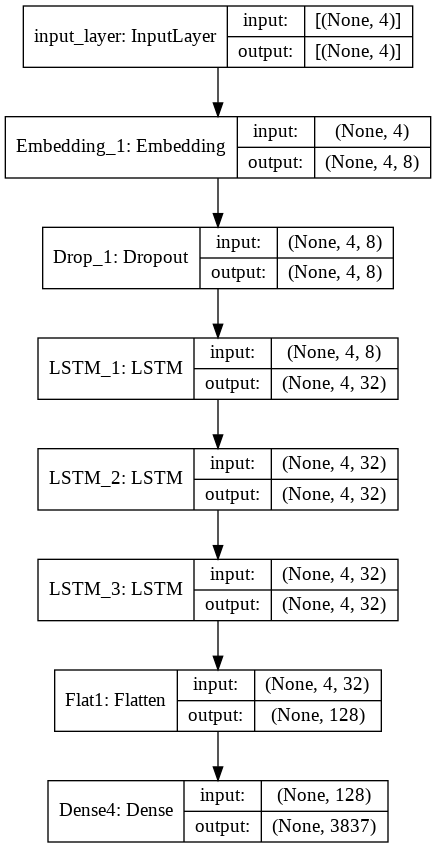

In [ ]:
model= TG_LSTM()
plot_model(model,show_shapes=True,show_layer_names=True,to_file='TG_LSTM.png')

In [ ]:
#@title Model Summary

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
Embedding_1 (Embedding)      (None, 4, 8)              30696     
_________________________________________________________________
Drop_1 (Dropout)             (None, 4, 8)              0         
_________________________________________________________________
LSTM_1 (LSTM)                (None, 4, 32)             5248      
_________________________________________________________________
LSTM_2 (LSTM)                (None, 4, 32)             8320      
_________________________________________________________________
LSTM_3 (LSTM)                (None, 4, 32)             8320      
_________________________________________________________________
Flat1 (Flatten)              (None, 128)               0     

In [ ]:

rms= RMSprop(learning_rate=0.0001,rho=0.9,momentum=0.95)
model.compile(loss='sparse_categorical_crossentropy',optimizer=rms,
            metrics=[
                    'accuracy',
            ])
history = model.fit(Batch_Train,
                    epochs=100, validation_data=Batch_Val
                    )

Epoch 1/100
8370/8370 [==============================] - 958s 112ms/step - loss: 8.0026 - accuracy: 0.0156 - val_loss: 7.6021 - val_accuracy: 0.0121
Epoch 2/100
8370/8370 [==============================] - 118s 14ms/step - loss: 7.3241 - accuracy: 0.0164 - val_loss: 7.3858 - val_accuracy: 0.0121
Epoch 3/100
8370/8370 [==============================] - 120s 14ms/step - loss: 7.1745 - accuracy: 0.0193 - val_loss: 7.2056 - val_accuracy: 0.0141
Epoch 4/100
8370/8370 [==============================] - 119s 14ms/step - loss: 7.0332 - accuracy: 0.0232 - val_loss: 7.0472 - val_accuracy: 0.0222
Epoch 5/100
8370/8370 [==============================] - 119s 14ms/step - loss: 6.9151 - accuracy: 0.0263 - val_loss: 6.9310 - val_accuracy: 0.0262
Epoch 6/100
8370/8370 [==============================] - 119s 14ms/step - loss: 6.8813 - accuracy: 0.0282 - val_loss: 6.8676 - val_accuracy: 0.0333
Epoch 7/100
8370/8370 [==============================] - 120s 14ms/step - loss: 6.7796 - accuracy: 0.0314 - val

## Plot Loss and Accuracy graph

In [ ]:
def plot_metrics(metric_name,title,ymin=0,ylim=5):

    plt.title(title)
    #plt.ylim(ymin,ylim)
    plt.plot(history.history[metric_name],color='blue', label=metric_name)
    plt.plot(history.history['val_'+metric_name],color='green',label='val_'+metric_name)
    plt.show()


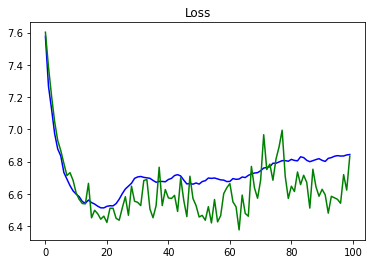

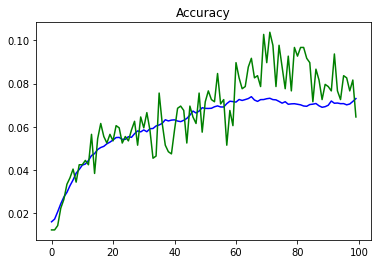

In [ ]:
plot_metrics(metric_name='loss',title='Loss',ylim=1)
plot_metrics(metric_name='accuracy',title='Accuracy',ymin=0.003,ylim=0.012)

In [ ]:
model.save("model_LSTM")

INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


In [ ]:
model_LSTM = tf.keras.models.load_model('model_LSTM')

In [ ]:
vectorize_text('باد')

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 0, 0, 0])>

In [ ]:
def sample(preds, temperature=0.2):
    # helper function to sample an index from a probability array
    preds=np.squeeze(preds)

    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
def generate_text(model, seed_original, step):
    seed= vectorize_text(seed_original)
    decode_sentence(seed.numpy().squeeze())
    for diversity in np.arange(0.2,2.6,0.2):
        print("...Diversity:", diversity)
        seed= vectorize_text(seed_original).numpy().reshape(1,-1)


        generated = (seed)
        for i in range(step):
            #print(seed.shape)
            predictions=model.predict(seed)
            pred_max= np.argmax(predictions.squeeze())
            #print("pred_max: ", pred_max)
            next_index = sample(predictions, diversity)
            #print("next_index: ", next_index)
            generated = np.append(generated, next_index)
            seed= generated[-sequence_length:].reshape(1,sequence_length)
        decode_sentence(generated)




In [ ]:
def decode_sentence (encoded_sentence):
  deceoded_sentence=[]

  SenLen = len(encoded_sentence)
  encoded_sentence = encoded_sentence[SenLen::-1]
  for word in encoded_sentence:

    deceoded_sentence.append(vectorize_layer.get_vocabulary()[word])
  sentence= ' '.join(deceoded_sentence)


  print(sentence)
  return sentence


In [ ]:
generate_text(model_LSTM,
              'صبا',
              10 )

   صبا
...Diversity: 0.2
کآفت این تیغ زنهارت صنع رفتهٔ پیرامن وفا این وصل    صبا
...Diversity: 0.4
سعدی دوست تربیتست مراد برآرد بردارم عود رویت این وصل    صبا
...Diversity: 0.6000000000000001
دوست باغ جای نرگس نمی‌گویی سعدیا دوست این چشم بتا    صبا
...Diversity: 0.8
تناور تقصیر شب گفتم مستور غمش چالاکترست شیرین پای نهاده‌ایم    صبا
...Diversity: 1.0
بوی کنم حسنی خواهم بخش شکیب عشق این جان بگذشت    صبا
...Diversity: 1.2
بیزاری معشوق دهان چشم طاعت ضلال ببینم جنت دوستان ناتوان    صبا
...Diversity: 1.4000000000000001
فرامش دست دست سعدی زلف عدمند جور جنت باری نمی‌خواهم    صبا
...Diversity: 1.6
غم نمی‌پردازم حدیث خواب دوست بدوز یاران می‌دهد قامت طناز    صبا
...Diversity: 1.8
عذرت ساحل جان صبحم خرامان سکونم گلاله ناپدیدست دشمنان ساقی    صبا
...Diversity: 2.0
همی‌برد بداند معنی عشقت دردا سیراب مویی می‌کنم عهد بخست    صبا
...Diversity: 2.2
جهان آرزوی بنان آسوده دیوانگیم نمی‌سوزد دشمنم زان دست خارت    صبا
...Diversity: 2.4000000000000004
سروقد ممتاز حذر چوگان قمر کنند سایبان منه خردمند بیاور    

## Here there are the refences that I have used in this assignment.


[Illustrated Guide to LSTM’s](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

[Machine Learning mastery](https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/)